In [3]:
#
###### https://github.com/LucaCanali/Miscellaneous/blob/master/Pyspark_SQL_Magic_Jupyter/IPython_Pyspark_SQL_Magic.py
#
#
# IPython magic functions to use with Pyspark and Spark SQL
# The following code is intended as examples of shorcuts to simplify the use of SQL in pyspark
# The defined functions are:
#
# %sql <statement>          - return a Spark DataFrame for lazy evaluation of the SQL
# %sql_show <statement>     - run the SQL statement and show max_show_lines (50) lines
# %sql_display <statement>  - run the SQL statement and display the results using a HTML table 
#                           - this is implemented passing via Pandas and displays up to max_show_lines (50)
# %sql_explain <statement>  - display the execution plan of the SQL statement
#
# Use: %<magic> for line magic or %%<magic> for cell magic.
#
# Author: Luca.Canali@cern.ch
# September 2016
#

from IPython.core.magic import register_line_cell_magic

# Configuration parameters
max_show_lines = 50         # Limit on the number of lines to show with %sql_show and %sql_display
detailed_explain = True     # Set to False if you want to see only the physical plan when running explain


@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line 
    return sqlContext.sql(val)

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line 
    return sqlContext.sql(val).show(max_show_lines) 

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return sqlContext.sql(val).limit(max_show_lines).toPandas() 

@register_line_cell_magic
def sql_explain(line, cell=None):
    "Display the execution plan of the sql. Use: %sql_explain or %%sql_explain"
    val = cell if cell is not None else line 
    return sqlContext.sql(val).explain(detailed_explain)


In [4]:
##############################
###### Load The Delta   ######
##############################
###
### Input delta in folder :  /data 
my_input_delta_table="delta_real_estate_term_definitions"
###
######
##############################Execution##########################
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
import subprocess
#
sc = pyspark.SparkContext(appName="Business_Dictionary-Delta")
sqlContext = SQLContext(sc)
#
#
internal_delta_files="file:///home/notebookuser/notebooks/data/"+my_input_delta_table
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
### use version=1
version=1
## .option("versionAsOf", version)
delta_dataframe_df1=sqlContext.read.format("delta").load(internal_delta_files)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
##.read.format("delta").load("/delta/events")
#
delta_dataframe_df1.printSchema()
delta_dataframe_df1.registerTempTable("real_estate_terms")
#

root
 |-- Real_Estate_Term: string (nullable = true)
 |-- Real_Estate_Definition: string (nullable = true)



In [5]:
%%sql_show
select * from real_estate_terms limit 20

+--------------------+----------------------+
|    Real_Estate_Term|Real_Estate_Definition|
+--------------------+----------------------+
| Acceleration clause|  Also known as an ...|
|   Active contingent|  When a seller acc...|
|Active under cont...|  A house is listed...|
|            Addendum|  If a buyer or sel...|
|Adjustable-rate m...|  The interest rate...|
|     Adjustment date|  This is the date ...|
|        Amortization|  Amortization is t...|
|Annual percentage...|  The annual percen...|
|           Appraisal|  An appraisal on y...|
|        Appreciation|  Appreciation is t...|
|      Assessed value|  An assessment is ...|
|          Assignment|  An assignment is ...|
|  Assumable mortgage|  Assumption is whe...|
|    Balloon mortgage|  Instead of a trad...|
|  Bi-weekly mortgage|  A bi-weekly mortg...|
|         Bridge loan|  A bridge loan is ...|
|              Broker|  A broker has pass...|
|             Buydown|  A buydown is a mo...|
|         Call option|  A call opt

In [6]:
%%sql_show
select * from real_estate_terms limit where Real_Estate_Term like '%Broker%' OR Real_Estate_Term like '%mortgage%'

+--------------------+----------------------+
|    Real_Estate_Term|Real_Estate_Definition|
+--------------------+----------------------+
|Adjustable-rate m...|  The interest rate...|
|  Assumable mortgage|  Assumption is whe...|
|    Balloon mortgage|  Instead of a trad...|
|  Bi-weekly mortgage|  A bi-weekly mortg...|
|              Broker|  A broker has pass...|
|A conventional mo...|       Convertible ARM|
|A convertible adj...|  Cost of funds ind...|
|A deed-in-lieu of...|               Default|
|If a homeowner de...|           Delinquency|
|A mortgage is con...|       Discount points|
|Discount points a...|          Down payment|
|A due-on-sale cla...|  Earnest money dep...|
|Home equity is th...|                Escrow|
|A fixed-rate mort...|     For sale by owner|
|If a homeowner do...|  Home Equity Conve...|
|The Home Equity C...|  Home equity line ...|
|When you purchase...|  Judicial foreclosure|
|Conforming loan l...|          Lease option|
|Residential loan ...|      Loan o

In [7]:
####
#### Expose most frequent Real-estate Terms in definitions
####
mywords=sqlContext.sql("select Real_Estate_Definition from real_estate_terms")\
.select(explode(split(col("Real_Estate_Definition"), "\s+")).alias("real_estate_term"))
#.explode("Real_Estate_Definition","term_word") ##( line  => line.split(" ") )
###
mywords.printSchema()
####
filler_words_list=['the','a','of','to','is','or','in','on','for','by','an','The','and','A',\
                   'your','as','that','when','their','it','be','with','you','are','--','It','from','can','usually']
####
wordCountDF = mywords\
.filter(~(col("real_estate_term").isin(filler_words_list)))\
.groupBy("real_estate_term").count().orderBy(col('count').desc())
####        
wordCountDF.show()

root
 |-- real_estate_term: string (nullable = true)

+----------------+-----+
|real_estate_term|count|
+----------------+-----+
|            loan|   37|
|        mortgage|   32|
|        property|   28|
|          seller|   27|
|           buyer|   22|
|        interest|   19|
|         monthly|   19|
|          lender|   18|
|            home|   17|
|        borrower|   17|
|          estate|   15|
|            real|   14|
|            rate|   13|
|           loan.|   11|
|         payment|   11|
|       property.|   11|
|             pay|   10|
|          amount|   10|
|           owner|   10|
|        payments|   10|
+----------------+-----+
only showing top 20 rows



In [8]:
%%sql_show
select * from real_estate_terms where Real_Estate_Term like '%Broker%' OR Real_Estate_Term like '%mortgage%'

+--------------------+----------------------+
|    Real_Estate_Term|Real_Estate_Definition|
+--------------------+----------------------+
|Adjustable-rate m...|  The interest rate...|
|  Assumable mortgage|  Assumption is whe...|
|    Balloon mortgage|  Instead of a trad...|
|  Bi-weekly mortgage|  A bi-weekly mortg...|
|              Broker|  A broker has pass...|
|A conventional mo...|       Convertible ARM|
|A convertible adj...|  Cost of funds ind...|
|A deed-in-lieu of...|               Default|
|If a homeowner de...|           Delinquency|
|A mortgage is con...|       Discount points|
|Discount points a...|          Down payment|
|A due-on-sale cla...|  Earnest money dep...|
|Home equity is th...|                Escrow|
|A fixed-rate mort...|     For sale by owner|
|If a homeowner do...|  Home Equity Conve...|
|The Home Equity C...|  Home equity line ...|
|When you purchase...|  Judicial foreclosure|
|Conforming loan l...|          Lease option|
|Residential loan ...|      Loan o

In [9]:
%%sql_explain
select * from real_estate_terms where Real_Estate_Term like '%Broker%' OR Real_Estate_Term like '%mortgage%'

== Parsed Logical Plan ==
'Project [*]
+- 'Filter ('Real_Estate_Term LIKE %Broker% || 'Real_Estate_Term LIKE %mortgage%)
   +- 'UnresolvedRelation `real_estate_terms`

== Analyzed Logical Plan ==
Real_Estate_Term: string, Real_Estate_Definition: string
Project [Real_Estate_Term#662, Real_Estate_Definition#663]
+- Filter (Real_Estate_Term#662 LIKE %Broker% || Real_Estate_Term#662 LIKE %mortgage%)
   +- SubqueryAlias `real_estate_terms`
      +- Relation[Real_Estate_Term#662,Real_Estate_Definition#663] parquet

== Optimized Logical Plan ==
Filter (Contains(Real_Estate_Term#662, Broker) || Contains(Real_Estate_Term#662, mortgage))
+- InMemoryRelation [Real_Estate_Term#662, Real_Estate_Definition#663], StorageLevel(disk, memory, 2 replicas)
      +- *(1) FileScan parquet [Real_Estate_Term#662,Real_Estate_Definition#663] Batched: true, Format: Parquet, Location: TahoeLogFileIndex[file:/home/notebookuser/notebooks/data/delta_real_estate_term_definitions], PartitionFilters: [], PushedFilters:

In [10]:
%%sql_display
select * from real_estate_terms where Real_Estate_Term like '%Broker%' OR Real_Estate_Term like '%mortgage%'

,Real_Estate_Term,Real_Estate_Definition
0,Adjustable-rate mortgage (ARM),The interest rate for an adjustable-rate mortg...
1,Assumable mortgage,Assumption is when a seller transfers all term...
2,Balloon mortgage,Instead of a traditional fixed-rate mortgage i...
3,Bi-weekly mortgage,A bi-weekly mortgage payment means a homeowner...
4,Broker,A broker has passed a broker’s license exam an...
5,A conventional mortgage is a loan not guarante...,Convertible ARM
6,A convertible adjustable rate mortgage (ARM) a...,Cost of funds index (COFI)
7,A deed-in-lieu of foreclosure is a document tr...,Default
8,"If a homeowner defaults on their loan, it mean...",Delinquency
9,A mortgage is considered delinquent when a sch...,Discount points


In [11]:
#####################################################
###### Real Estate Term - Ngram4 Most-Frequent  #####
#####################################################
#
delta_real_estate_term_folder="delta_terms_words_ngrams_real_estate"
input_delta="file:///home/notebookuser/notebooks/data/"+delta_real_estate_term_folder
#
from pyspark.sql import functions as F
### use version=1
version=1
## .option("versionAsOf", version)
delta_dataframe_df1=sqlContext.read.format("delta").load(input_delta)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
##.read.format("delta").load("/delta/events")
#
delta_dataframe_df1.printSchema()
delta_dataframe_df1.registerTempTable("real_estate_ngram4_terms")
#
print("Load table real_estate_ngram4_terms - Finished!")

root
 |-- Real_Estate_Term: string (nullable = true)
 |-- Real_Estate_Definition: string (nullable = true)
 |-- hash_real_estate_term: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ngrams_4: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ngramscounts_4: vector (nullable = true)
 |-- features_15: vector (nullable = true)

Load table real_estate_ngram4_terms - Finished!


In [12]:
#### Expose most frequent Real-estate Terms in definitions for Mortgages as NGram4
####
mywords=sqlContext.sql("select real_estate_ngram4_terms.ngrams_4 as real_ngram4 from real_estate_ngram4_terms")\
.select(explode(col("real_ngram4")).alias("real_estate_term_ngram4"))
###
mywords.printSchema()
####
####
filler_words_list=['[]']
####
wordCountDF = mywords\
.filter(~(col("real_estate_term_ngram4").isin(filler_words_list)))\
.groupBy("real_estate_term_ngram4").count().orderBy(col('count').desc())
####        
wordCountDF.show(60,0)
#
print("Calculate top 100 most frequent real_estate_ngram4_terms - Finished!")

root
 |-- real_estate_term_ngram4: string (nullable = true)

+-----------------------------+-----+
|real_estate_term_ngram4      |count|
+-----------------------------+-----+
|lowering the buyer s         |2    |
|the buyer and seller         |2    |
|bank or financial institution|2    |
|the borrower is unable       |2    |
|has accepted an offer        |2    |
|transfer of a property       |2    |
|the amount you owe           |2    |
|party the right to           |2    |
|seller has accepted an       |2    |
|of a property s              |2    |
|also known as a              |2    |
|a real estate transaction    |2    |
|of real estate transactions  |2    |
|if the buyer is              |2    |
|is the amount of             |2    |
|terms and conditions of      |2    |
|from the seller to           |2    |
|to the borrower s            |2    |
|owner of the property        |2    |
|an offer from a              |2    |
|commonly referred to as      |2    |
|if the borrower is        

In [13]:
%%sql_display
select * from real_estate_ngram4_terms where  real_estate_ngram4_terms.ngrams_4[0] IS NOT NULL

,Real_Estate_Term,Real_Estate_Definition,hash_real_estate_term,words,ngrams_4,ngramscounts_4,features_15
0,Acceleration clause,"Also known as an acceleration covenant, this i...",51eb6544402bf1f36642b5b6e5ae65fdf32e03dd6e6540...,"[also, known, as, an, acceleration, covenant, ...","[also known as an, known as an acceleration, a...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
1,Active contingent,"When a seller accepts an offer from a buyer, t...",bdb2cb7c9c4034d3f4b948966479bf56aafc43773b013e...,"[when, a, seller, accepts, an, offer, from, a,...","[when a seller accepts, a seller accepts an, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
2,Active under contract,A house is listed as “active under contract” w...,750ad509f8f8110e0b38c4cad8b2b6f7d123a17045e528...,"[a, house, is, listed, as, active, under, cont...","[a house is listed, house is listed as, is lis...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Addendum,If a buyer or seller want to change an existin...,8cb4147706e508af9b220c320af8b01b55ce88d31fe5a1...,"[if, a, buyer, or, seller, want, to, change, a...","[if a buyer or, a buyer or seller, buyer or se...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(7.0, 1.0, 2.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,Adjustable-rate mortgage (ARM),The interest rate for an adjustable-rate mortg...,a8c737487d6540a8789e7950f2bcd124e17c883ada8902...,"[the, interest, rate, for, an, adjustable, rat...","[the interest rate for, interest rate for an, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, ..."
5,Adjustment date,This is the date your mortgage begins to accru...,dd8612fa526c4ebc79f94c16f36bd18af253836bc2119b...,"[this, is, the, date, your, mortgage, begins, ...","[this is the date, is the date your, the date ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 3.0, 0.0, ..."
6,Amortization,Amortization is the schedule of your mortgage ...,449edd5d1ecb7e241abe8cf2817c4b51a4339f73fe203d...,"[amortization, is, the, schedule, of, your, mo...","[amortization is the schedule, is the schedule...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, ..."
7,Annual percentage rate (APR),The annual percentage rate (APR) is the amount...,0bfc15ca780fea82243c83723cd917e52098e337b6361f...,"[the, annual, percentage, rate, apr, is, the, ...","[the annual percentage rate, annual percentage...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
8,Appraisal,An appraisal on your home is an unbiased estim...,d4e869d28b41ce3863e08433b88694f209afed38e3906f...,"[an, appraisal, on, your, home, is, an, unbias...","[an appraisal on your, appraisal on your home,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(8.0, 3.0, 1.0, 1.0, 4.0, 0.0, 1.0, 0.0, 0.0, ..."
9,Appreciation,Appreciation is the amount a home increases in...,106a0f385d7fcf0996f437e1ed9b8d8e9229f3ead0d145...,"[appreciation, is, the, amount, a, home, incre...","[appreciation is the amount, is the amount a, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 3.0, 5.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."


In [14]:
%%sql_display
select * from real_estate_ngram4_terms where  real_estate_ngram4_terms.ngrams_4[0] IS NOT NULL
AND ( real_estate_ngram4_terms.ngrams_4[0] LIKE '%transfer of a property%' OR
       real_estate_ngram4_terms.ngrams_4[1] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[2] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[3] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[4] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[5] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[6] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[7] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[8] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[9] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[10] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[11] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[12] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[13] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[14] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[15] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[16] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[17] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[18] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[19] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[20] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[21] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[22] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[23] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[24] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[25] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[26] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[27] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[28] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[29] LIKE '%transfer of a property%' OR
      real_estate_ngram4_terms.ngrams_4[30] LIKE '%transfer of a property%'
    )

,Real_Estate_Term,Real_Estate_Definition,hash_real_estate_term,words,ngrams_4,ngramscounts_4,features_15
0,Transfer of ownership,"In real estate, transfer of ownership refers t...",ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...,"[in, real, estate, transfer, of, ownership, re...","[in real estate transfer, real estate transfer...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
1,Transfer tax,Transfer tax is a transaction fee charged upon...,86891a4d8a455a8ef5d8280a899cf196d9ef368e930b72...,"[transfer, tax, is, a, transaction, fee, charg...","[transfer tax is a, tax is a transaction, is a...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 2.0, 0.0, 1.0, 5.0, 3.0, 0.0, 0.0, 2.0, ..."


In [15]:
########################
##### Plot Results #####  
########################
#
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas
#
mywords=sqlContext.sql("select hash_real_estate_term, Real_Estate_Term as real_estate_term, ngrams_4 \
from real_estate_ngram4_terms \
where real_estate_ngram4_terms.ngrams_4[0] IS NOT NULL AND \
( real_estate_ngram4_terms.ngrams_4[0] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[1] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[2] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[3] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[4] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[5] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[6] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[7] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[8] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[9] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[10] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[11] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[12] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[13] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[14] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[15] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[16] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[17] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[18] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[19] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[20] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[21] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[22] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[23] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[24] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[25] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[26] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[27] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[28] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[29] LIKE '%transfer of a property%' OR \
real_estate_ngram4_terms.ngrams_4[30] LIKE '%transfer of a property%' ) LIMIT 10")\
.withColumn("idcount1", monotonically_increasing_id())\
.withColumn("ngrams4", explode(col('ngrams_4'))).drop(col('ngrams_4'))\
.withColumn("idcount2", monotonically_increasing_id())
#
mywords.printSchema()
#
mywords.show(80,0)
#

root
 |-- hash_real_estate_term: string (nullable = true)
 |-- real_estate_term: string (nullable = true)
 |-- idcount1: long (nullable = false)
 |-- ngrams4: string (nullable = true)
 |-- idcount2: long (nullable = false)

+----------------------------------------------------------------+---------------------+--------+-----------------------------------+--------+
|hash_real_estate_term                                           |real_estate_term     |idcount1|ngrams4                            |idcount2|
+----------------------------------------------------------------+---------------------+--------+-----------------------------------+--------+
|ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40581770f6c80b0c6a1b|Transfer of ownership|0       |in real estate transfer            |0       |
|ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40581770f6c80b0c6a1b|Transfer of ownership|0       |real estate transfer of            |1       |
|ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40581770f6c80b0c

In [16]:
#
#
pdt=mywords.toPandas()
t=pdt
#
print(t)
#

                                hash_real_estate_term       real_estate_term  \
0   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
1   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
2   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
3   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
4   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
5   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
6   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
7   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
8   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
9   ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
10  ed757eaa91c2c7b7e1ae76ada0f63a2372e97b77b62d40...  Transfer of ownership   
11  ed757eaa91c2c7b7e1ae76ada0f63a2372e9

In [31]:
sc.stop()

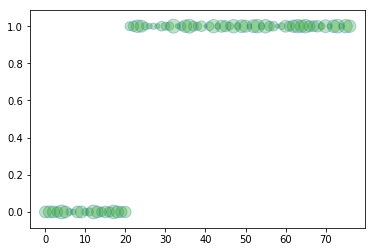

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(19680801)

dataframe = t
x = t.idcount2
y = t.idcount1
ngram4tag=t.ngrams4
scale=200.0 * np.random.rand(100)
color1='tab:green'
color2='tab:blue'

plt.scatter(x, y, c=color1, s=scale, label=ngram4tag, alpha=0.3, edgecolors=color2)
plt.show()  # or plt.savefig("name.png")

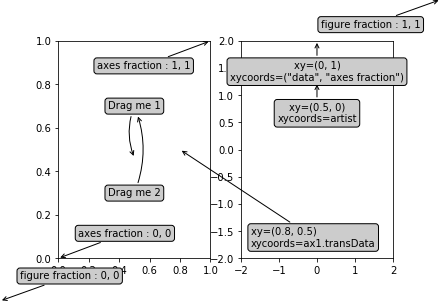

In [2]:
###########################################################
#######   {Plot colides with PySpark + Pandas Dataframes} #
#######   {Plot needs to be in a separate Notebook}       #
###########################################################
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from matplotlib.text import OffsetFrom

fig, (ax1, ax2) = plt.subplots(1, 2)

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

# Here we'll demonstrate the extents of the coordinate system and how
# we place annotating text.

ax1.annotate('figure fraction : 0, 0', xy=(0, 0), xycoords='figure fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",
             bbox=bbox_args,
             arrowprops=arrow_args)

ax1.annotate('figure fraction : 1, 1', xy=(1, 1), xycoords='figure fraction',
             xytext=(-20, -20), textcoords='offset points',
             ha="right", va="top",
             bbox=bbox_args,
             arrowprops=arrow_args)

ax1.annotate('axes fraction : 0, 0', xy=(0, 0), xycoords='axes fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",
             bbox=bbox_args,
             arrowprops=arrow_args)

ax1.annotate('axes fraction : 1, 1', xy=(1, 1), xycoords='axes fraction',
             xytext=(-20, -20), textcoords='offset points',
             ha="right", va="top",
             bbox=bbox_args,
             arrowprops=arrow_args)

# It is also possible to generate draggable annotations

an1 = ax1.annotate('Drag me 1', xy=(.5, .7), xycoords='data',
                   #xytext=(.5, .7), textcoords='data',
                   ha="center", va="center",
                   bbox=bbox_args,
                   #arrowprops=arrow_args
                   )

an2 = ax1.annotate('Drag me 2', xy=(.5, .5), xycoords=an1,
                   xytext=(.5, .3), textcoords='axes fraction',
                   ha="center", va="center",
                   bbox=bbox_args,
                   arrowprops=dict(patchB=an1.get_bbox_patch(),
                                   connectionstyle="arc3,rad=0.2",
                                   **arrow_args))
an1.draggable()
an2.draggable()

an3 = ax1.annotate('', xy=(.5, .5), xycoords=an2,
                   xytext=(.5, .5), textcoords=an1,
                   ha="center", va="center",
                   bbox=bbox_args,
                   arrowprops=dict(patchA=an1.get_bbox_patch(),
                                   patchB=an2.get_bbox_patch(),
                                   connectionstyle="arc3,rad=0.2",
                                   **arrow_args))

# Finally we'll show off some more complex annotation and placement

text = ax2.annotate('xy=(0, 1)\nxycoords=("data", "axes fraction")',
                    xy=(0, 1), xycoords=("data", 'axes fraction'),
                    xytext=(0, -20), textcoords='offset points',
                    ha="center", va="top",
                    bbox=bbox_args,
                    arrowprops=arrow_args)

ax2.annotate('xy=(0.5, 0)\nxycoords=artist',
             xy=(0.5, 0.), xycoords=text,
             xytext=(0, -20), textcoords='offset points',
             ha="center", va="top",
             bbox=bbox_args,
             arrowprops=arrow_args)

ax2.annotate('xy=(0.8, 0.5)\nxycoords=ax1.transData',
             xy=(0.8, 0.5), xycoords=ax1.transData,
             xytext=(10, 10),
             textcoords=OffsetFrom(ax2.bbox, (0, 0), "points"),
             ha="left", va="bottom",
             bbox=bbox_args,
             arrowprops=arrow_args)

ax2.set(xlim=[-2, 2], ylim=[-2, 2])
plt.show()